# Parameter scheduling

_30 July 2021_ <br />
_Chuan-Zheng Lee <czlee@stanford.edu>_ <br />
_Rough working_

In digital schemes, this compares "aligned" parameter scheduling with "staggered" parameter scheduling, as implemented in [`b63fc83`](https://github.com/czlee/jadeite/commit/b63fc833d8c0e3ef7fbe46cdcb8edb2d61f5e9a9).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from plots_utils import plot_averaged_training_charts, plot_comparison, make_axes, show_timestamp_info

In [2]:
def get_base_specs(dataset, parameter_schedule, clients, noise, lr_client=0.01, momentum_client=0.0):
    
    fixed_specs = {
        'rounds': 150,
        'batch_size': 64,
        'epochs': 1,
        'ema_coefficient': 1 / 3,
        'qrange_update_period': 1,
        'qrange_param_quantile': 0.9,
        'qrange_client_quantile': 0.9,
        'data_per_client': 20000 if dataset == 'epsilon' else None,
        'channel_uses': None,
        'rounding_method': 'stochastic',
        'send': 'deltas',
        'zero_bits_strategy': 'read-zero',
        'save_squared_error': [False, '__missing__'],
    }
    title_specs = {
        'power': 1.0,
        'clients': clients,
        'parameter_schedule': parameter_schedule,
        'dataset': dataset,
        'lr_client': lr_client,
        'momentum_client': momentum_client,
    }
    series_specs = {
        'noise': noise,
    }
    fields = ['accuracy']
    return fields, title_specs, fixed_specs, series_specs

def plot_aligned_vs_staggered(digital_path, dataset, clients, noise, **kwargs):
    axs = make_axes(2)
    specs = get_base_specs(dataset, 'aligned', clients, noise, **kwargs)
    plot_averaged_training_charts(digital_path, *specs, plot_range=True, plot_quartiles=True, axs=axs[0:1])
    specs = get_base_specs(dataset, 'staggered', clients, noise, **kwargs)
    plot_averaged_training_charts(digital_path, *specs, plot_range=True, plot_quartiles=True, axs=axs[1:2])

def get_comparison_specs(dataset, parameter_schedule, clients, noise, lr_client=0.01, momentum_client=0.0):

    common_fixed_specs = {
        'rounds': 150,
        'batch_size': 64,
        'epochs': 1,
        'ema_coefficient': 1 / 3,
        'data_per_client': 20000 if dataset == 'epsilon' else None,
        'save_squared_error': [False, '__missing__'],
        }

    fixed_specs = common_fixed_specs.copy()
    fixed_specs.update({
        'power_update_period': 1,
        'power_quantile': 0.9,
        'power_factor': 0.9,
    })
    title_specs = {
        'power': 1.0,
        'send': 'deltas',
        'clients': clients,
        'dataset': dataset,
        'lr_client': lr_client,
        'momentum_client': momentum_client,
    }
    series_specs = {
        'noise': noise,
    }

    all_analog_specs = title_specs, fixed_specs, series_specs

    fixed_specs = common_fixed_specs.copy()
    fixed_specs.update({
        'qrange_update_period': 1,
        'qrange_param_quantile': 0.9,
        'qrange_client_quantile': 0.9,
        'channel_uses': None,
        'rounding_method': ['stochastic', '__missing__'],
    })
    title_specs = title_specs.copy()
    title_specs.update({
        'parameter_schedule': parameter_schedule,
        'zero_bits_strategy': 'read-zero',
    })

    all_digital_specs = title_specs, fixed_specs, series_specs
    
    return all_analog_specs, all_digital_specs

def plot_analog_vs_digital(paths, dataset, clients, noise, **kwargs):
    axs = make_axes(2)
    all_specs = get_comparison_specs(dataset, 'aligned', clients, noise, **kwargs)
    plot_comparison('accuracy', *paths, *all_specs, ax=axs[0])
    all_specs = get_comparison_specs(dataset, 'staggered', clients, noise, **kwargs)
    plot_comparison('accuracy', *paths, *all_specs, ax=axs[1])

# Logistic regression on epsilon

In [3]:
analog_path = [
    Path("results/20210722-dynpower-2/"),
    Path("results/20210723-lownoise-dynpower"),
    Path("results/20210724-epsilon-dynpower"),
    Path("results/20210725-epsilon-dynpower"),
]
digital_path = [
    Path("results/20210728-aligned-vs-staggered/"),
    Path("results/20210807-staggered-dynquant-epsilon"),
]
paths = analog_path, digital_path

## aligned vs staggered

In [4]:
show_timestamp_info(digital_path)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **28 Jul 2021, 07:14:54** | 28 Jul 2021, 11:18:03 | 4 h 03 min 08 s |
| last to finish | 08 Aug 2021, 03:41:31 | **08 Aug 2021, 04:16:01** | 34 min 29 s |
| shortest | 28 Jul 2021, 23:44:40 | 28 Jul 2021, 23:55:32 | **10 min 51 s** |
| longest | 28 Jul 2021, 07:15:49 | 28 Jul 2021, 11:23:17 | **4 h 07 min 27 s** |


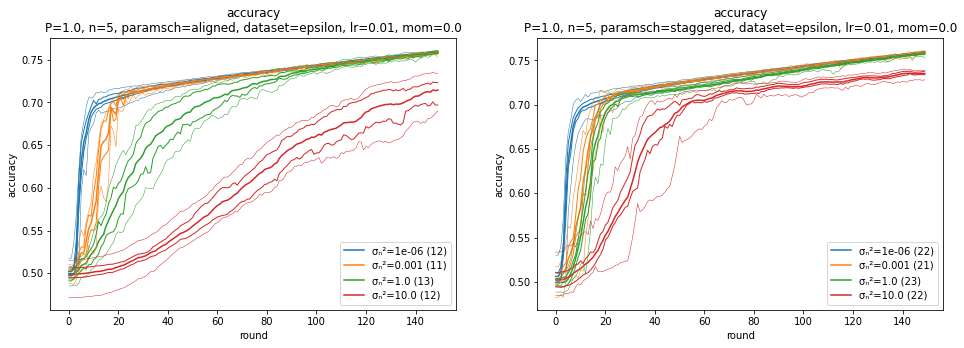

In [5]:
plot_aligned_vs_staggered(digital_path, 'epsilon', 5, [1e-6, 1e-3, 1.0, 10.0])

The `aligned` plot is consistent with the plots in dynamic-1.ipynb (as it should be), so that's a good sign there's not a regression here.

The `staggered` plot is definitely an improvement.

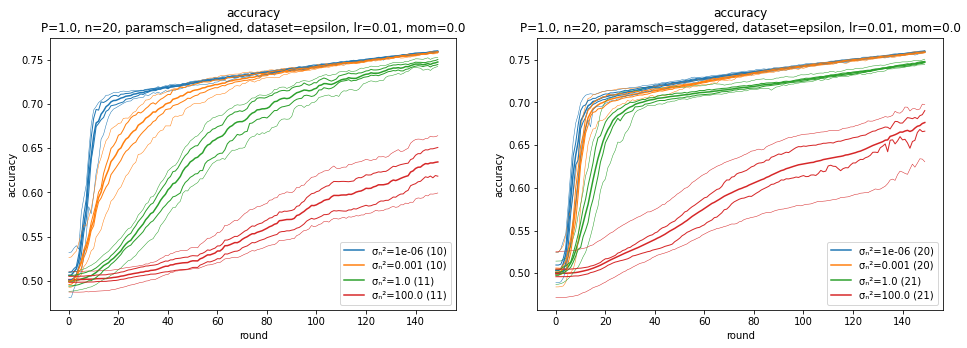

In [6]:
plot_aligned_vs_staggered(digital_path, 'epsilon', 20, [1e-6, 1e-3, 1.0, 100.0])

Also a clear improvement.

### analog vs digital

Using the same results as in dynamic-1.ipynb.

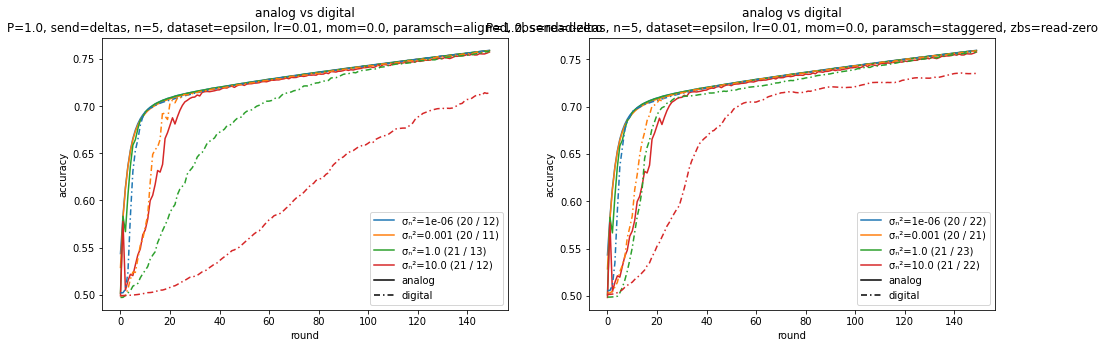

In [7]:
plot_analog_vs_digital(paths, 'epsilon', 5, [1e-6, 1e-3, 1.0, 10.0])

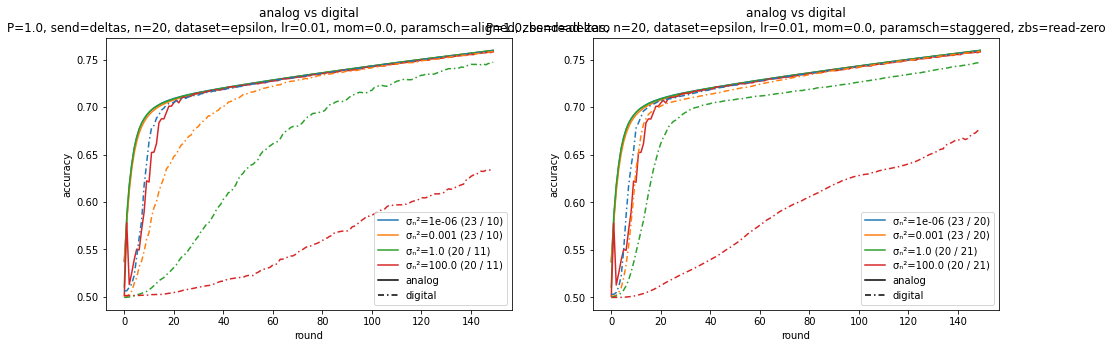

In [8]:
plot_analog_vs_digital(paths, 'epsilon', 20, [1e-6, 1e-3, 1.0, 100.0])

# CIFAR-10 with lr 0.01, momentum 0


In [9]:
analog_path = [
    Path("results/20210724-other-datasets-dynpower/"),
    Path("results/20210725-other-datasets-dynpower/"),
    Path("results/20210801-dynpower-cifarfmnist"),
]
digital_path = [
    Path("results/20210729-paramsched-cifarfmnist/"),
    Path("results/20210730-paramsched-cifarfmnist/"),
    Path("results/20210801-staggered-dynquant-cifarfmnist/"),
    Path("results/20210808-staggered-dynquant-cifarfmnist/"),
]
paths = analog_path, digital_path
show_timestamp_info(digital_path)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **29 Jul 2021, 08:04:59** | 29 Jul 2021, 08:27:42 | 22 min 43 s |
| last to finish | 08 Aug 2021, 11:04:31 | **08 Aug 2021, 11:25:31** | 21 min 00 s |
| shortest | 29 Jul 2021, 13:37:40 | 29 Jul 2021, 13:58:26 | **20 min 46 s** |
| longest | 31 Jul 2021, 20:13:25 | 31 Jul 2021, 20:54:54 | **41 min 28 s** |


### aligned vs staggered

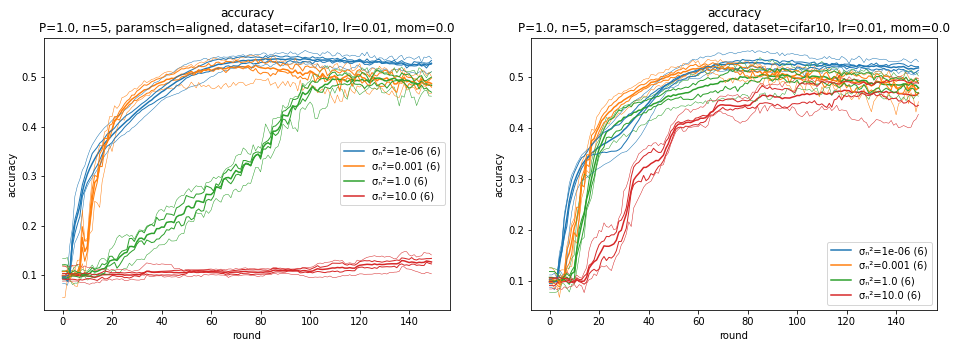

In [10]:
plot_aligned_vs_staggered(digital_path, 'cifar10', 5, [1e-6, 1e-3, 1.0, 10.0])

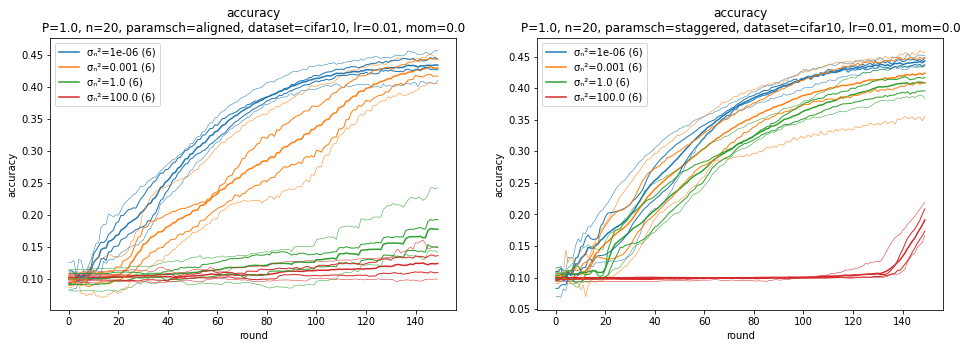

In [11]:
plot_aligned_vs_staggered(digital_path, 'cifar10', 20, [1e-6, 1e-3, 1.0, 100.0])

### analog vs digital

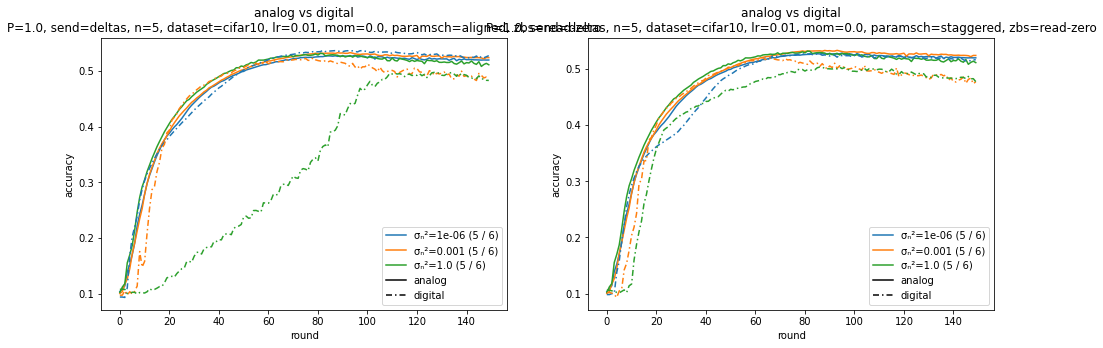

In [12]:
plot_analog_vs_digital(paths, 'cifar10', 5, [1e-6, 1e-3, 1.0])

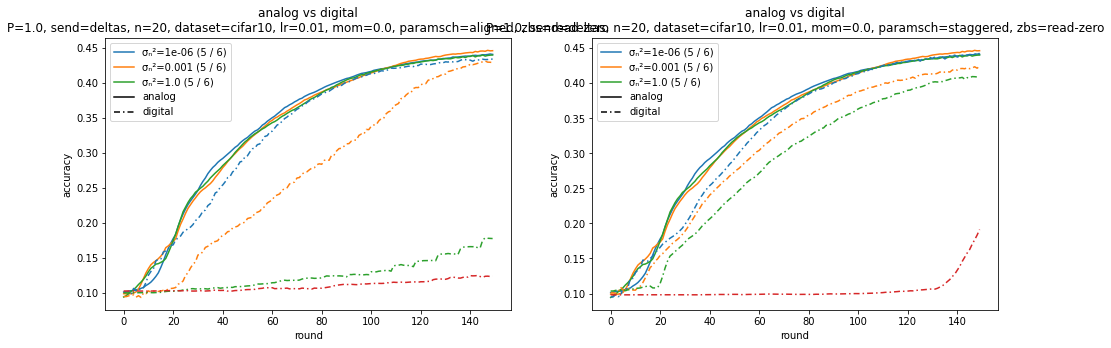

In [13]:
plot_analog_vs_digital(paths, 'cifar10', 20, [1e-6, 1e-3, 1.0, 100.0])

# Fashion-MNIST

### aligned vs staggered

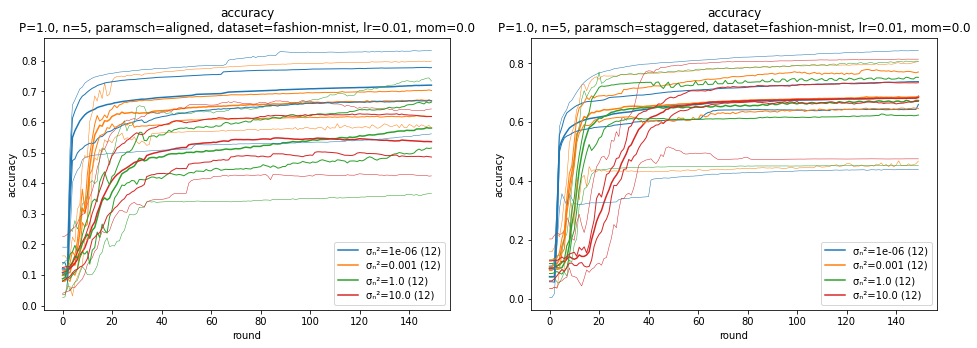

In [14]:
plot_aligned_vs_staggered(digital_path, 'fashion-mnist', 5, [1e-6, 1e-3, 1.0, 10.0])

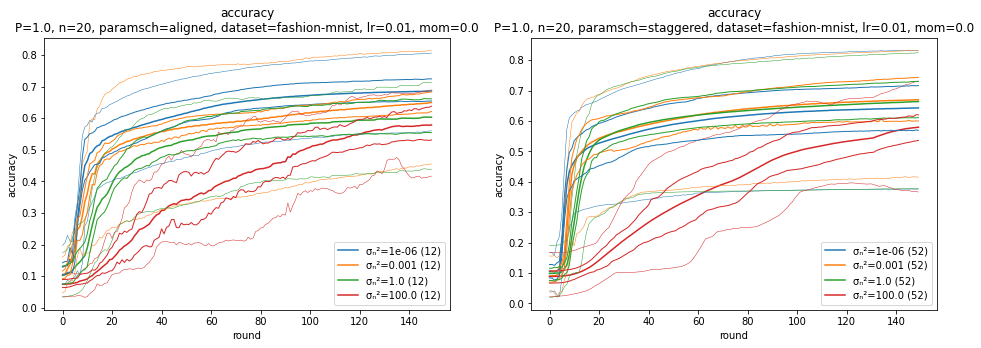

In [15]:
plot_aligned_vs_staggered(digital_path, 'fashion-mnist', 20, [1e-6, 1e-3, 1.0, 100.0])

### analog vs digital

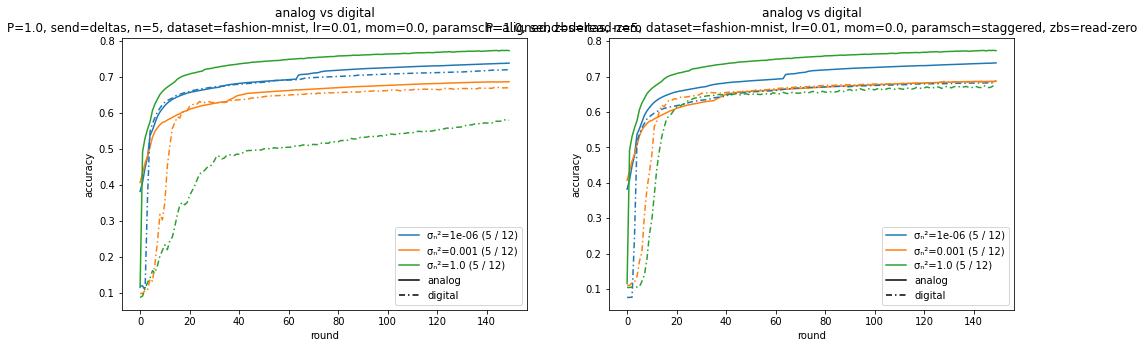

In [16]:
plot_analog_vs_digital(paths, 'fashion-mnist', 5, [1e-6, 1e-3, 1.0])

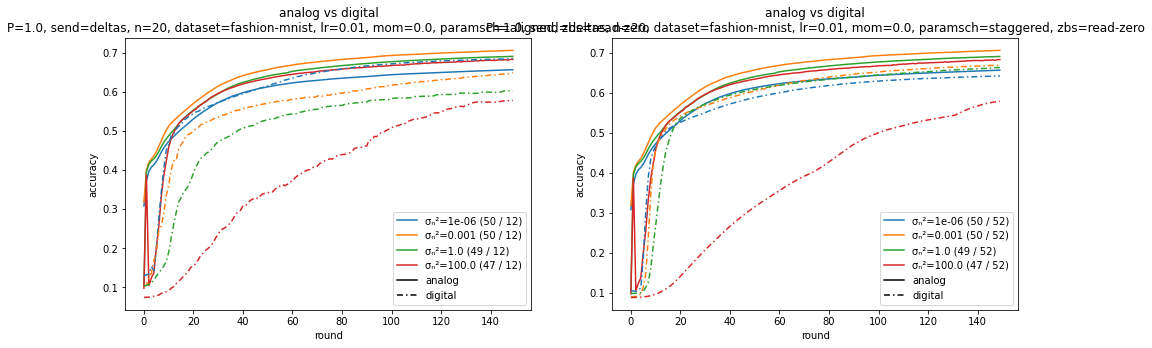

In [17]:
plot_analog_vs_digital(paths, 'fashion-mnist', 20, [1e-6, 1e-3, 1.0, 100.0])

# CIFAR-10 with lr 0.001, momentum 0.9

### aligned vs staggered

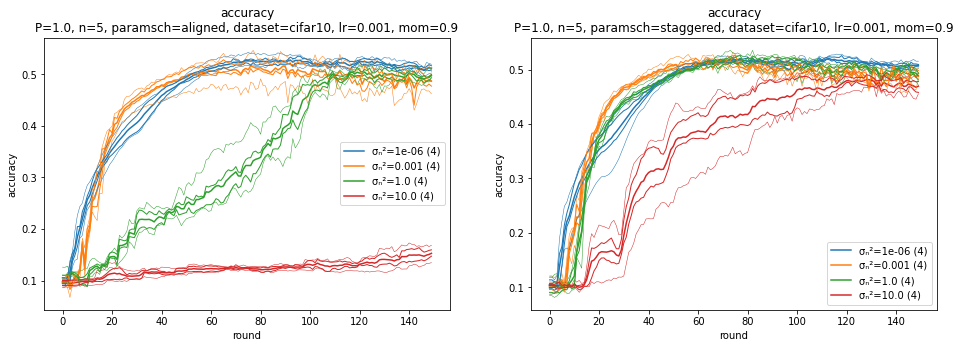

In [18]:
plot_aligned_vs_staggered(digital_path, 'cifar10', 5, [1e-6, 1e-3, 1.0, 10.0], lr_client=0.001, momentum_client=0.9)

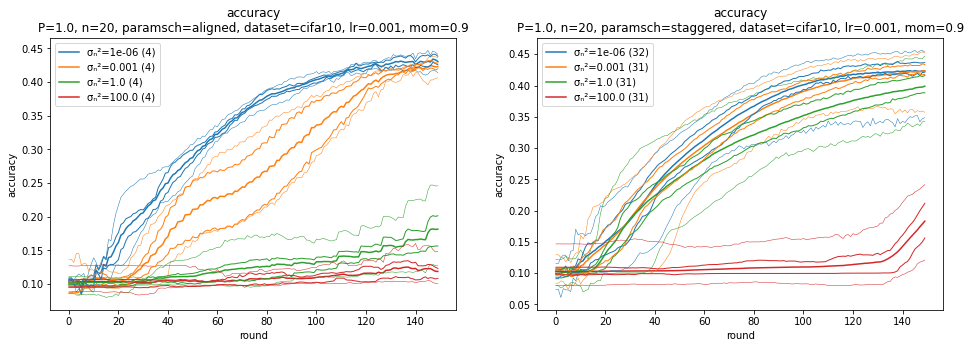

In [19]:
plot_aligned_vs_staggered(digital_path, 'cifar10', 20, [1e-6, 1e-3, 1.0, 100.0], lr_client=0.001, momentum_client=0.9)

### analog vs digital

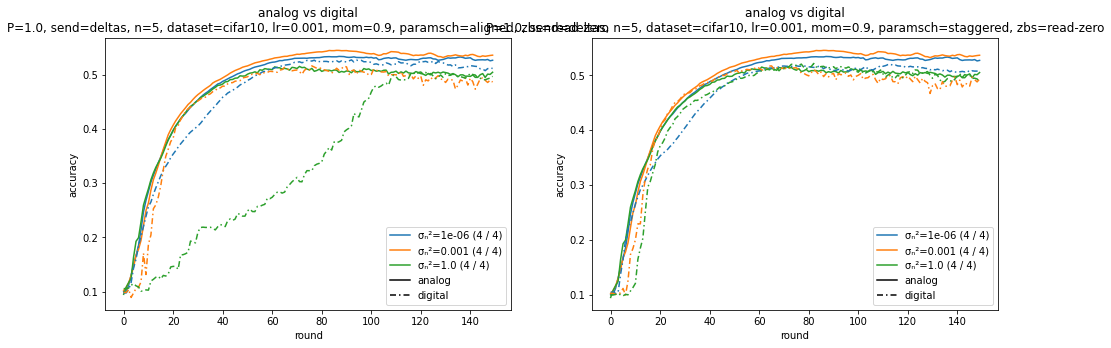

In [20]:
plot_analog_vs_digital(paths, 'cifar10', 5, [1e-6, 1e-3, 1.0], lr_client=0.001, momentum_client=0.9)

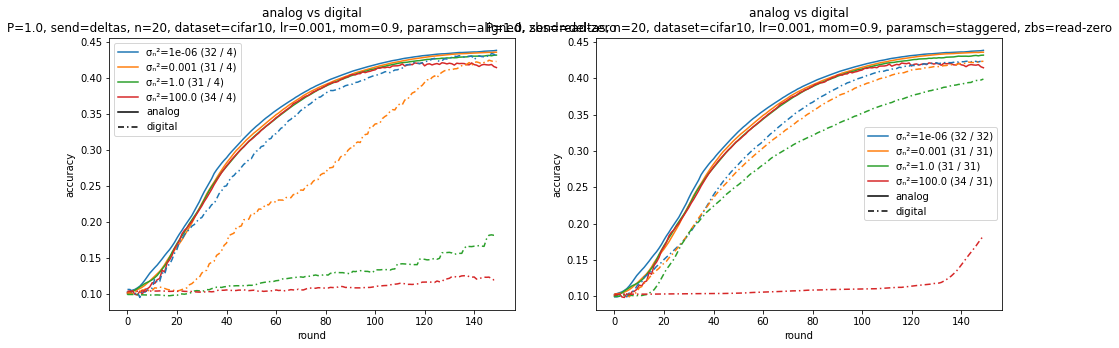

In [21]:
plot_analog_vs_digital(paths, 'cifar10', 20, [1e-6, 1e-3, 1.0, 100.0], lr_client=0.001, momentum_client=0.9)